<a href="https://colab.research.google.com/github/vochicong/ai-memo/blob/master/TF_Agents_Reinforcement_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TensorFlow Agentsで強化学習してみよう

## 準備

### gym や TF Agentsなどのインストール

In [0]:
!apt-get install xvfb
!pip install 'gym==0.10.11'
!pip install imageio
!pip install PILLOW
!pip install pyglet
!pip install pyvirtualdisplay
!pip install tf-agents-nightly
!pip install tf-nightly

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  xvfb
0 upgraded, 1 newly installed, 0 to remove and 6 not upgraded.
Need to get 783 kB of archives.
After this operation, 2,266 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.2 [783 kB]
Fetched 783 kB in 1s (948 kB/s)
Selecting previously unselected package xvfb.
(Reading database ... 131294 files and directories currently installed.)
Preparing to unpack .../xvfb_2%3a1.19.6-1ubuntu4.2_amd64.deb ...
Unpacking xvfb (2:1.19.6-1ubuntu4.2) ...
Setting up xvfb (2:1.19.6-1ubuntu4.2) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
  Stored in directory: /root/.cache/pip/wheels/d1/8c/16/1c64227974ae29c687e4cc30fd691d5c0

### import

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import base64
import gym
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay

import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.agents.dqn import q_network
from tf_agents.drivers import dynamic_episode_driver
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.environments import trajectory
from tf_agents.metrics import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.utils import common

tf.compat.v1.enable_v2_behavior()


# Set up a virtual display for rendering OpenAI gym environments.
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

### 設定

In [0]:
env_name = 'CartPole-v0'  # @param
num_iterations = 20000  # @param

initial_collect_steps = 1000  # @param
collect_steps_per_iteration = 10  # @param
replay_buffer_capacity = 100000  # @param

fc_layer_params = (100, 100) # @param

batch_size = 64  # @param
learning_rate = 1e-3  # @param
log_interval = 200  # @param

num_eval_episodes = 10  # @param
eval_interval = 1000  # @param

## Cartpole カートポール 倒立振子

[Cartpole](https://gym.openai.com/docs/#environments) は強化学習の Hello world 的問題です。

倒立振子が倒れないように、左か右へ移動(Action)できる。報酬の最大値は 200。

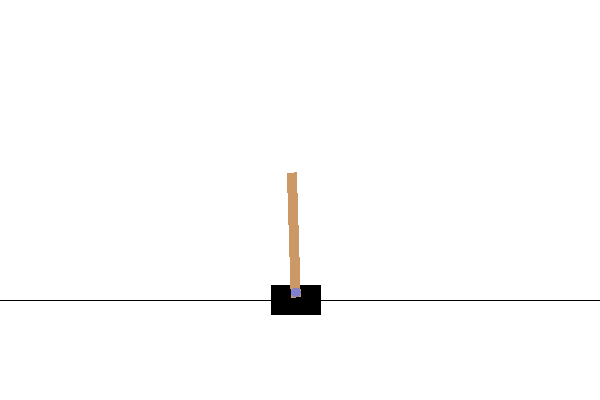

In [0]:
env = suite_gym.load(env_name)
env.reset()
PIL.Image.fromarray(env.render())

In [0]:
print('Observation Spec:')
print(env.time_step_spec().observation)
print('Action Spec:')
print(env.action_spec())

Observation Spec:
BoundedArraySpec(shape=(4,), dtype=dtype('float32'), name=None, minimum=[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], maximum=[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38])
Action Spec:
BoundedArraySpec(shape=(), dtype=dtype('int64'), name=None, minimum=0, maximum=1)


### Random 行動

大体 30 位の rewards （報酬）を得られる

#### TF suite_gym利用

In [0]:
env = suite_gym.load(env_name)
rewards = []
for i_episode in range(10):
    env.reset()
    for t in range(200):
        action = env.action_space.sample()
        next_step = env.step(action)
        assert 1 == next_step.reward
        if next_step.is_last():
          rewards.append(t+1)
          break

In [0]:
np.mean(rewards), rewards

(17.8, [13, 14, 20, 15, 18, 14, 29, 11, 20, 24])

#### OpenAI gym利用

In [0]:
env = gym.make(env_name)
rewards = []
for i_episode in range(10):
    env.reset()
    for t in range(100):
        action = env.action_space.sample()
        observation, reward, done, info = env.step(action)
        assert 1 == reward
        if done:
          rewards.append(t+1)
          break

In [0]:
np.mean(rewards), rewards

(24.1, [16, 15, 18, 22, 14, 51, 9, 55, 22, 19])

In [0]:
observation, reward, done, info

(array([ 0.16334031,  0.94156663, -0.22586632, -1.7119736 ]), 1.0, True, {})

### TF-AgentsでDQN強化学習

#### 訓練と評価用の Environment を用意

In [0]:
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

#### Agent

In [0]:
def create_agent(train_env):
    q_net = q_network.QNetwork(
      train_env.observation_spec(),
      train_env.action_spec(),
      fc_layer_params=fc_layer_params,
    )

    adam = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

    train_step_counter = tf.compat.v2.Variable(0)

    tf_agent = dqn_agent.DqnAgent(
        train_env.time_step_spec(),
        train_env.action_spec(),
        q_network=q_net,
        optimizer=adam,
        td_errors_loss_fn=dqn_agent.element_wise_squared_loss,
        train_step_counter=train_step_counter,
    )
    tf_agent.initialize()
    return tf_agent

#### Policies & Metrics


[tf_metrics.AverageReturnMetric](https://github.com/tensorflow/agents/blob/dba93a7b2ebdd1d64e7a46822804b57ad11878d0/tf_agents/metrics/py_metrics.py#L110) で評価し、[TF Driver](https://github.com/tensorflow/agents/blob/master/tf_agents/colabs/4_drivers_tutorial.ipynb) で for loop を使わずに簡潔に記述。

In [0]:
random_policy = random_tf_policy.RandomTFPolicy(
  train_env.time_step_spec(),
  train_env.action_spec())

# 評価メソッド
def evaluate(env, policy, num_episodes=num_eval_episodes):
    observers = [tf_metrics.AverageReturnMetric()]
    dynamic_episode_driver.DynamicEpisodeDriver(
        env, policy, observers, num_episodes).run()
    return observers[0].result().numpy()

# Random policy を評価してみる
evaluate(eval_env, random_policy)

W0403 08:51:18.102041 139950747289472 backprop.py:818] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.int64
W0403 08:51:18.138677 139949368248064 backprop.py:818] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.int32
W0403 08:51:18.140618 139949368248064 backprop.py:818] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.int64
W0403 08:51:18.141865 139949368248064 backprop.py:818] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.int32
W0403 08:51:18.154871 139950747289472 backprop.py:818] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.int64


17.3

#### Replay Buffer & Data Collection

Environment から情報を収集。[TF Driver](https://github.com/tensorflow/agents/blob/master/tf_agents/colabs/4_drivers_tutorial.ipynb) で簡潔に記述できる。

In [0]:
def create_replay_buffer(tf_agent, train_env):
    replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
        data_spec=tf_agent.collect_data_spec,
        batch_size=train_env.batch_size,
        max_length=replay_buffer_capacity
    )
    print(replay_buffer.capacity.numpy(), replay_buffer._batch_size)
    print(replay_buffer.data_spec)
    return replay_buffer

def collect_data(replay_buffer, env, policy, n_steps):
    dynamic_step_driver.DynamicStepDriver(
        env, policy, [replay_buffer.add_batch], n_steps
    ).run()    
    return


#### TF-Agentの訓練

In [0]:
%%time

def train_agent():
    tf_agent = create_agent(train_env)
    
    replay_buffer = create_replay_buffer(tf_agent, train_env)
    collect_data(replay_buffer, train_env, random_policy, initial_collect_steps)
    dataset = replay_buffer.as_dataset(
        num_parallel_calls=3, sample_batch_size=batch_size, num_steps=2
    ).prefetch(3)
    iterator = iter(dataset)
    
    avg_return = evaluate(eval_env, tf_agent.policy, num_eval_episodes)
    returns = [avg_return]
    for step in range(1, 1+num_iterations):
        collect_data(replay_buffer,train_env, tf_agent.collect_policy, 
                     collect_steps_per_iteration)
        experience, _ = next(iterator)
        train_loss = tf_agent.train(experience)
        if step % log_interval == 0:
            print('Step = {}, Loss= {}'.format(step, train_loss.loss))
        if step % eval_interval == 0:
            avg_return = evaluate(eval_env, tf_agent.policy, num_eval_episodes)
            print('Step = {}, Average Return= {}'.format(step, avg_return))
            returns.append(avg_return)
    return returns
returns = train_agent()

100000 1
Trajectory(step_type=TensorSpec(shape=(), dtype=tf.int32, name='step_type'), observation=BoundedTensorSpec(shape=(4,), dtype=tf.float32, name=None, minimum=array([-4.8000002e+00, -3.4028235e+38, -4.1887903e-01, -3.4028235e+38],
      dtype=float32), maximum=array([4.8000002e+00, 3.4028235e+38, 4.1887903e-01, 3.4028235e+38],
      dtype=float32)), action=BoundedTensorSpec(shape=(), dtype=tf.int64, name=None, minimum=array(0), maximum=array(1)), policy_info=(), next_step_type=TensorSpec(shape=(), dtype=tf.int32, name='step_type'), reward=TensorSpec(shape=(), dtype=tf.float32, name='reward'), discount=BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)))
Step = 200, Loss= 7.634439468383789
Step = 400, Loss= 164.08152770996094
Step = 600, Loss= 612.979248046875
Step = 800, Loss= 453.0376281738281
Step = 1000, Loss= 168.9308319091797
Step = 1000, Average Return= 156.39999389648438
Step = 1200, Loss= 56.59

(1.6550004005432122, 210)

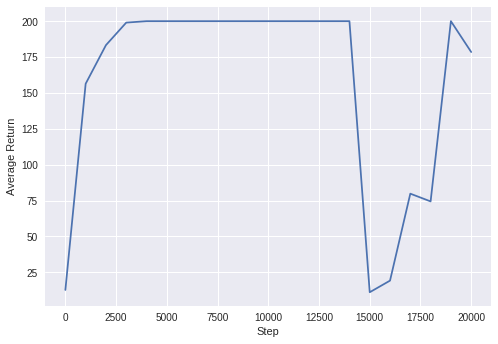

In [0]:
steps = range(0, num_iterations + 1, eval_interval)
plt.ylabel('Average Return')
plt.xlabel('Step')
plt.plot(steps, returns)
plt.ylim(top=210)

最大の報酬 200 が得られている。